### Imports

In [1]:
import numpy as np
import pandas as pd
import re
import warnings
import datetime

import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings("ignore")
import pickle
import scipy
from scipy import signal

In [2]:
#loads in functions
%run ../Files/functions.ipynb

### Loading in Files

In [3]:
filename = '../Files/optical_flow_df'
infile = open(filename,'rb')
of_df = pickle.load(infile)
infile.close()

In [4]:
filename = '../Files/mod_df'
infile = open(filename,'rb')
mod_df = pickle.load(infile)
infile.close()

In [5]:
filename = '../Files/mouse_vids'
infile = open(filename,'rb')
mouse_vids = pickle.load(infile)
infile.close()

In [6]:
flicker_vids = pd.read_csv("../Files/WtoR_videos.csv")

In [7]:
tvp = pd.read_csv("../Files/twitch_vs_pause.csv")

### Exploration of dataframe

In [8]:
mod_df.columns

Index(['dataset_name', 'video_filename', 'flicker_flavor',
       'percentile_normalized_flow', 'median_filter_pnf', 'traces'],
      dtype='object')

### Extracting R/W

In [9]:
video_names = mod_df["video_filename"].unique()

In [10]:
#stores all rw flickers
rw_flickers = {}

In [11]:
#stores all optical flow values corresponding to flicker intervals
rw_of = {}

In [12]:
#stores all median_filter values corresponding to flicker intervals
rw_pnf = {}

In [13]:
for video_name in video_names:
    video_df = mod_df.loc[mod_df['video_filename'] == video_name]
    flicker = video_df['flicker_flavor'].values
    groups = find_groups(flicker).get('REM_WITHIN_WAKE')
    
    vid_flickers = []
    if groups != None:
        for group in groups:
            if calculate_frames(group[0], group[1], 150) != None:
                vid_flickers.append(group)
        rw_flickers[video_name] = vid_flickers
    else:
        rw_flickers[video_name] = None

In [14]:
for i, video_name in enumerate(video_names):
    video_df = mod_df.loc[mod_df['video_filename'] == video_name]
    cur_flickers = rw_flickers.get(video_name)
    if cur_flickers != None:
        for flicker in cur_flickers:
            name, ants = annotations(video_name, video_df, flicker, 150, 'percentile_normalized_flow')
            rw_of[name] = ants
    else:
        rw_of[video_name] = None

In [15]:
for i, video_name in enumerate(video_names):
    video_df = mod_df.loc[mod_df['video_filename'] == video_name]
    cur_flickers = rw_flickers.get(video_name)
    if cur_flickers != None:
        for flicker in cur_flickers:
            name, ants = annotations(video_name, video_df, flicker, 150, 'median_filter_pnf')
            rw_pnf[name] = ants
    else:
        rw_pnf[video_name] = None

### Functions for Plotting

In [16]:
#cleans video name
def clean_list(raw_list):
    cleaned_vids = [x for x in raw_list if str(x) != 'nan']
    cleaned_vids = [(x + ".mp4") if len(x.split(".")) < 2 else x for x in cleaned_vids]
    
    return cleaned_vids

In [17]:
def plot_flow(video_name, arr):
    fig, ax = plt.subplots()
    vid_arr = arr.get(vid)

    plt.title(vid)
    
    ax.set_xticks(np.arange(0, 315, 15))
    ax.set_xticklabels(np.arange(-10, 11, 1))
    
    ax.set_ylim([0, 5.0])
    plt.plot(vid_arr)
    
    plt.show()

### Optical Flow Plots

In [18]:
flicker_vids

,CAF26,CAF34,CAF42
0,e3v819c-20200807T1509-1609_f3128-f3148.mp4,e3v819c-20200827T171404-181405_f670-f679.mp4,e3v81a6-20200914T182237-192238_f36758-f36781
1,e3v819c-20200807T1609-1709_f4344-f4377.mp4,e3v819c-20200827T171404-181405_f47977-f48007.mp4,e3v81a6-20200914T192238-202238_f17837-f17849
2,e3v819c-20200807T1609-1709_f13545-f13555.mp4,e3v819c-20200827T181405-191405_f11469-f11483.mp4,e3v81a6-20200914T202238-212239_f4627-f4643
3,e3v819c-20200807T1609-1709_f13812-f13817.mp4,e3v819c-20200827T181405-191405_f12633-f12641.mp4,e3v81a6-20200914T212239-222240_f24414-f24427
4,e3v819c-20200807T1609-1709_f13821-f13838.mp4,e3v819c-20200827T181405-191405_f20078-f20084.mp4,e3v81a6-20200914T232241-002242_f37820-f37835
5,e3v819c-20200807T1609-1709_f16213-f16226.mp4,e3v819c-20200827T191405-201406_f8734-f8749.mp4,e3v81a6-20200915T002242-012242_f43313-f43326
6,e3v819c-20200807T1709-1809_f33907-f33916.mp4,e3v819c-20200827T191405-201406_f42115-f42144.mp4,e3v81a6-20200915T022243-032244_f28799-f28808
7,e3v819c-20200807T2109-2209_f25048-f25062.mp4,e3v819c-20200827T201406-211406_f47171-f47192.mp4,e3v81a6-20200915T022243-032244_f43964-f43976
8,e3v819c-20200808T0209-0309_f2732-f2742.mp4,e3v819c-20200827T221407-231408_f1719-f1728.mp4,e3v81a6-20200915T042245-052246_f36200-f36214
9,e3v819c-20200808T0209-0309_f4200-f4268.mp4,e3v819c-20200827T221407-231408_f3770-f3781.mp4,e3v81a6-20200915T052246-062246_f2662-f2668


In [19]:
raw_vids = []

In [20]:
for column in flicker_vids:
    raw_vids.extend(flicker_vids[column].values)

In [21]:
#cleans all video names
cleaned_vids = clean_list(raw_vids)

In [196]:
# pdf = PdfPages('of_plots.pdf')

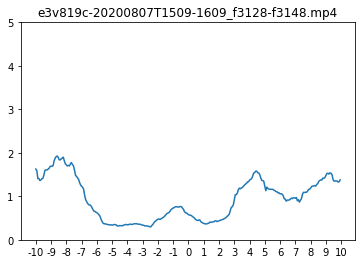

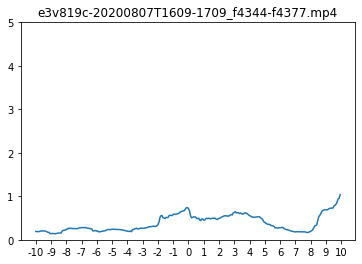

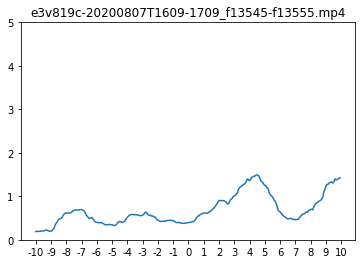

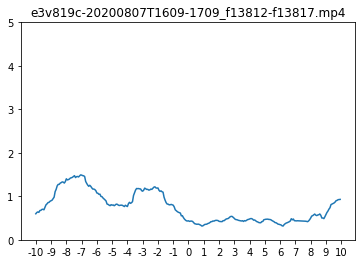

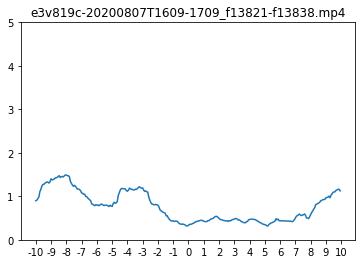

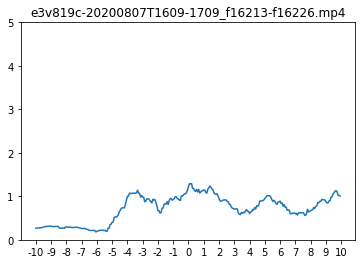

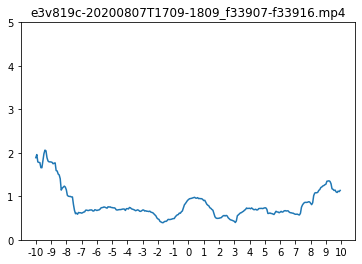

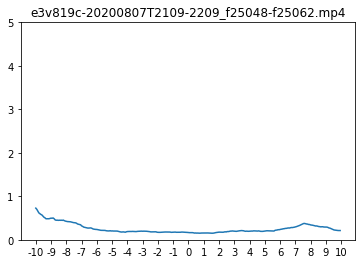

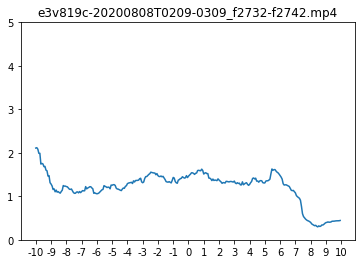

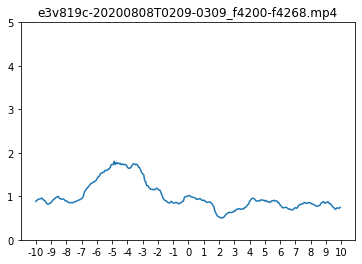

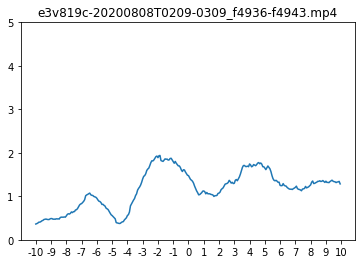

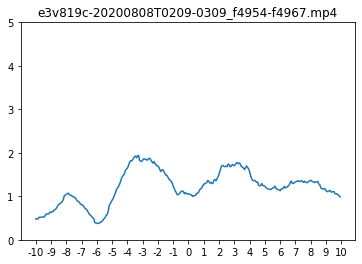

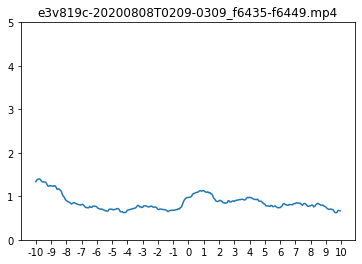

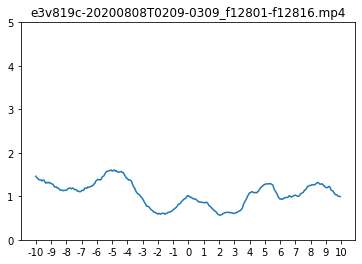

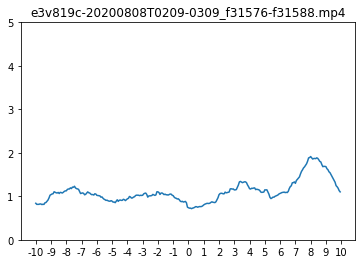

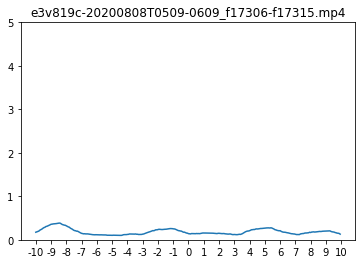

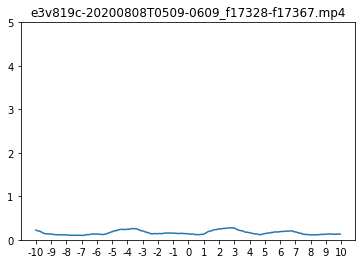

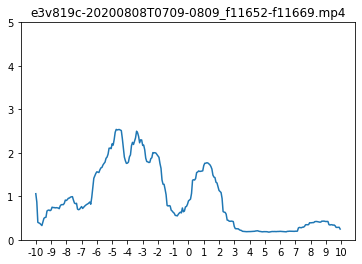

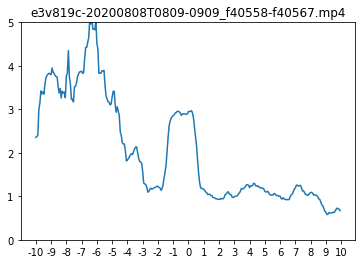

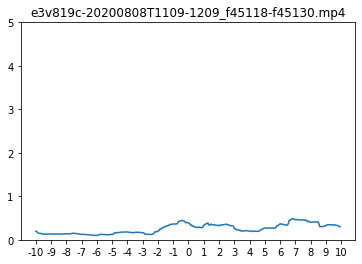

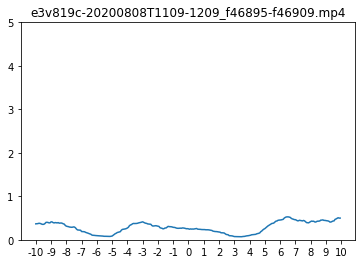

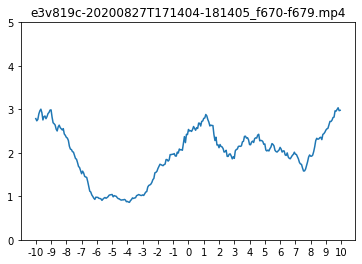

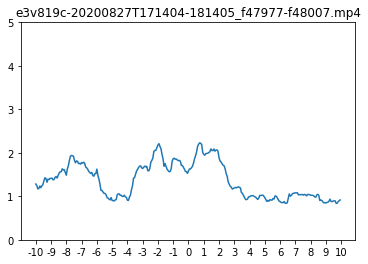

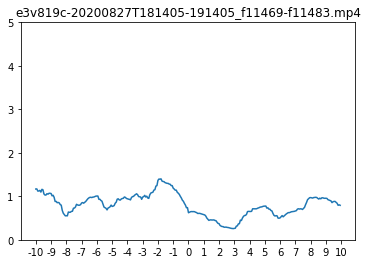

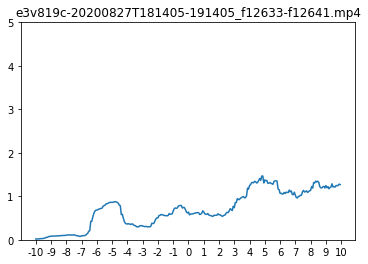

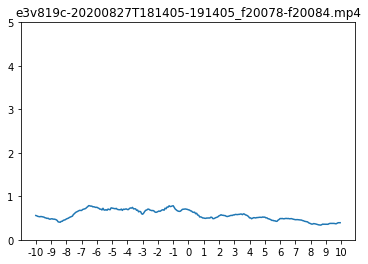

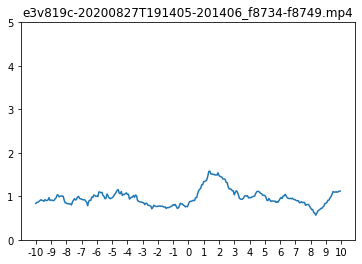

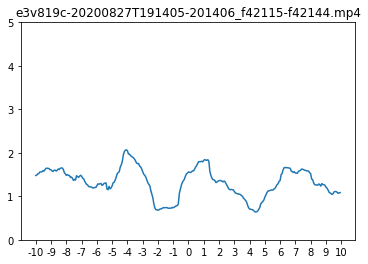

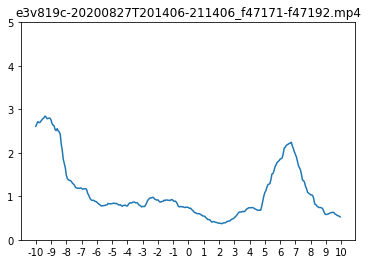

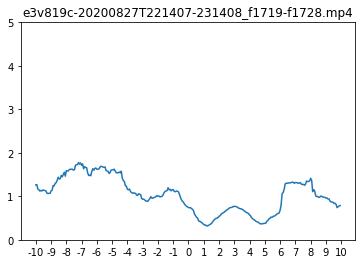

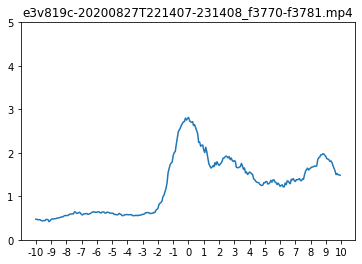

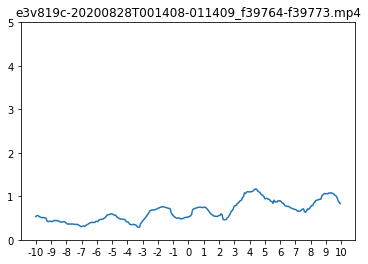

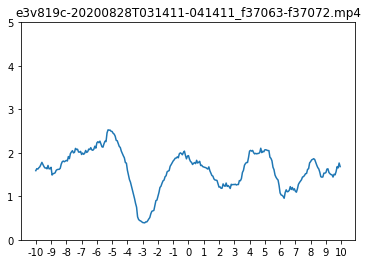

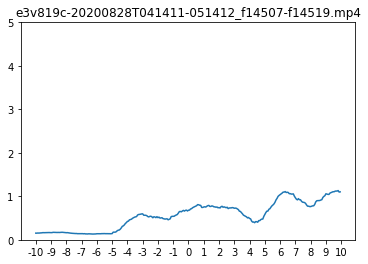

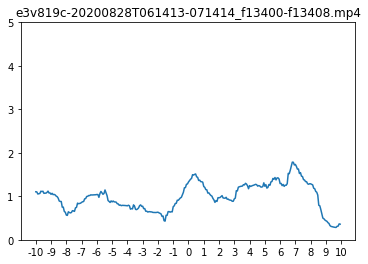

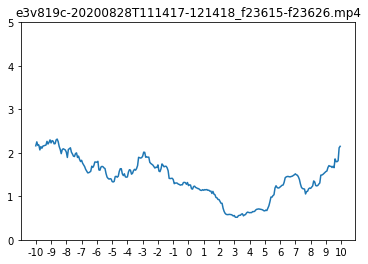

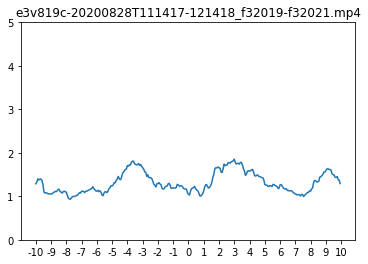

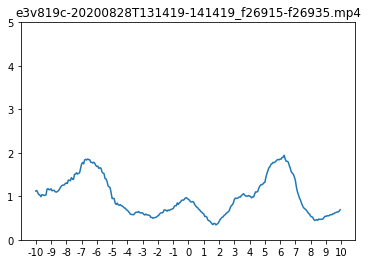

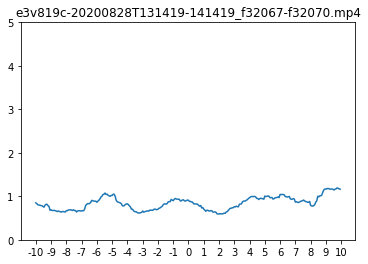

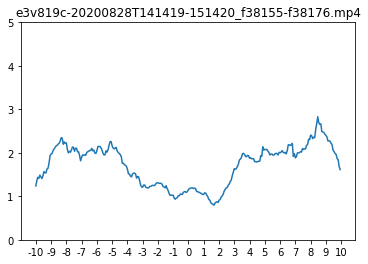

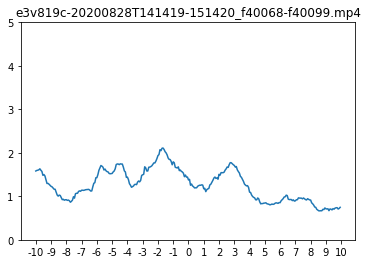

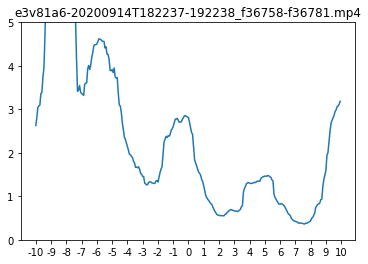

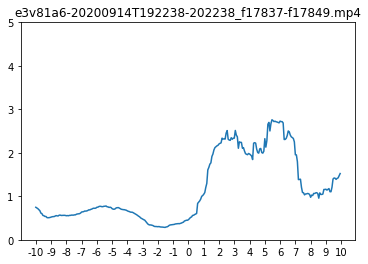

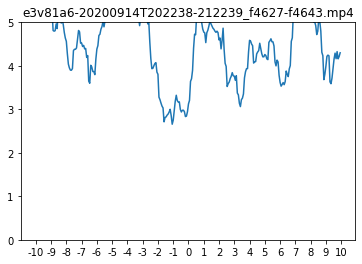

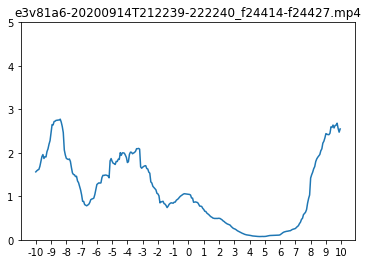

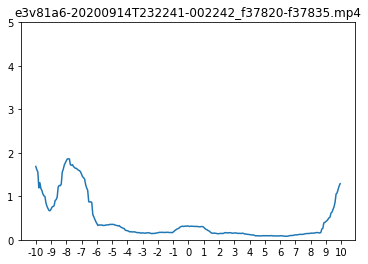

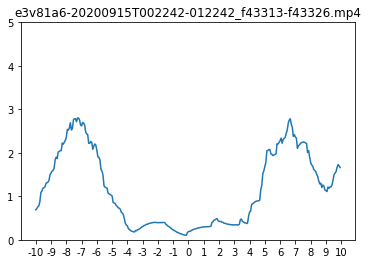

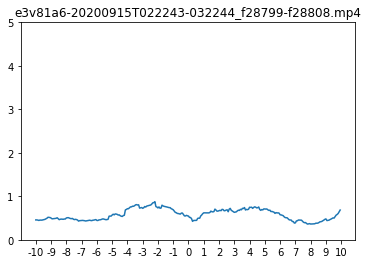

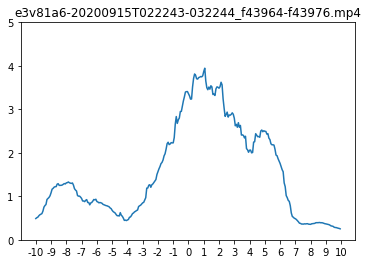

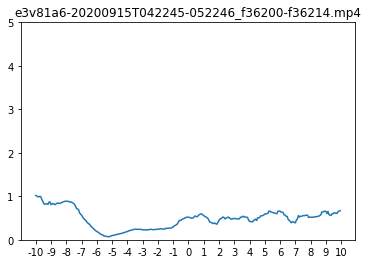

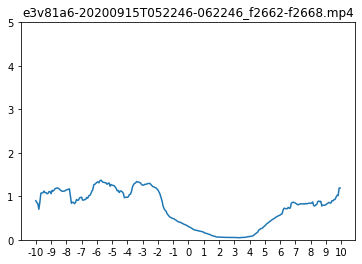

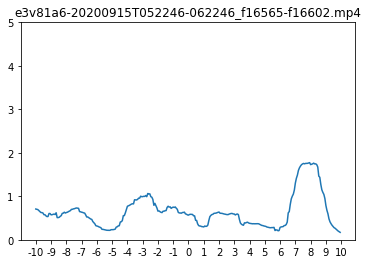

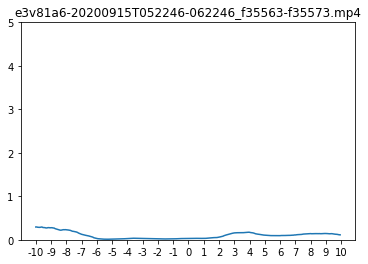

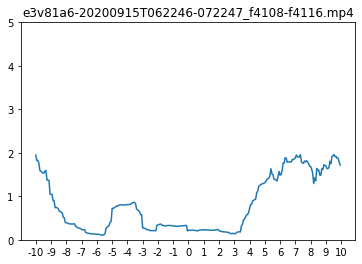

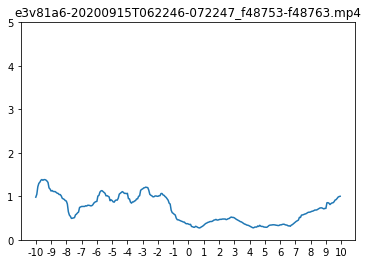

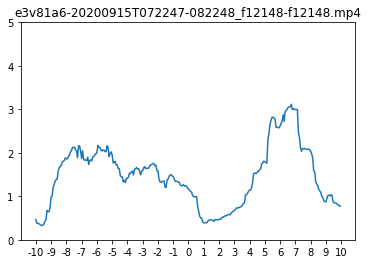

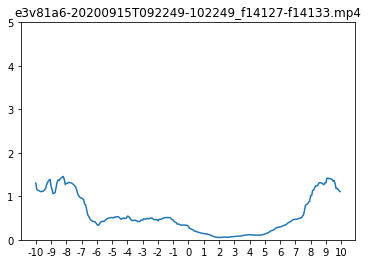

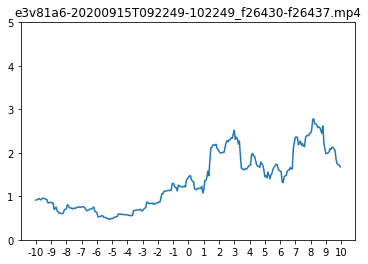

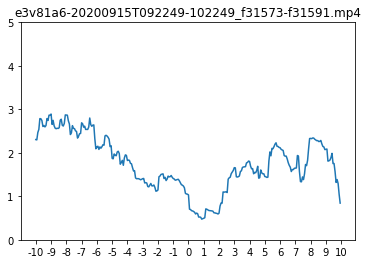

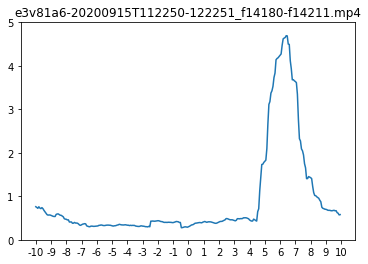

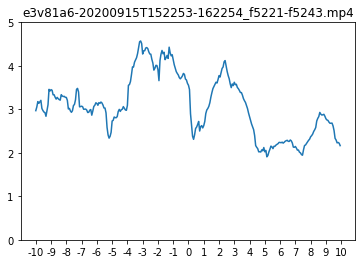

In [22]:
#plots optical flow
for vid in cleaned_vids:
    plot_flow(vid, rw_of)

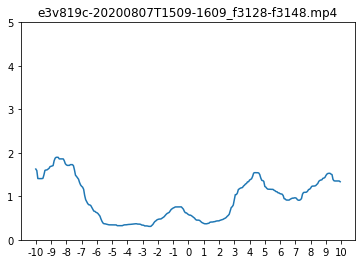

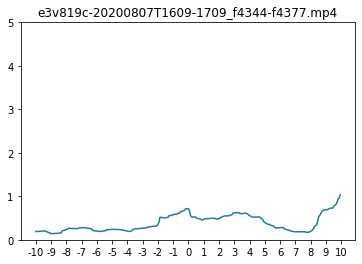

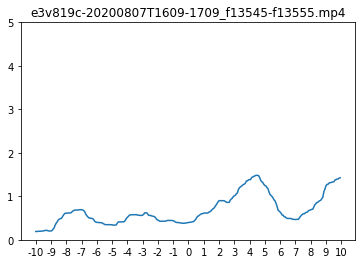

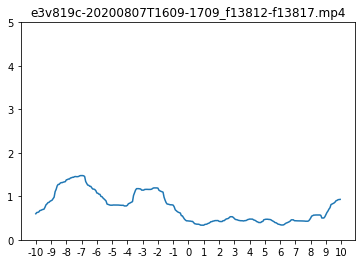

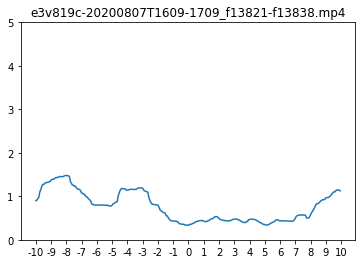

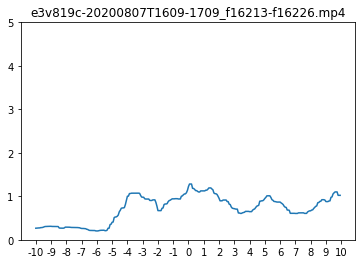

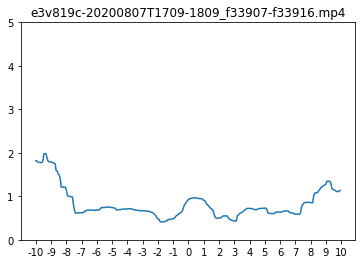

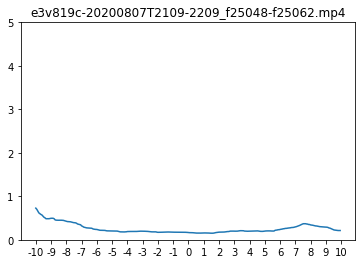

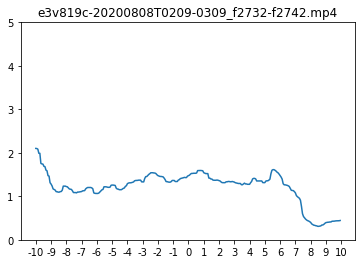

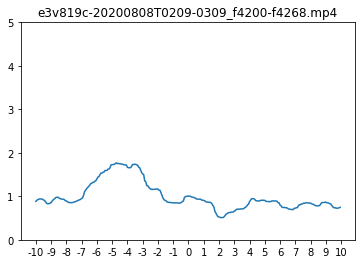

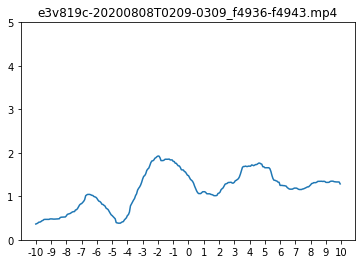

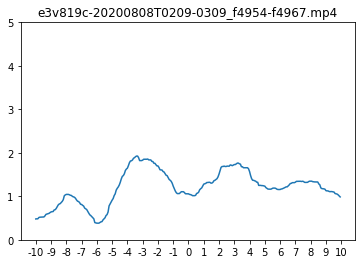

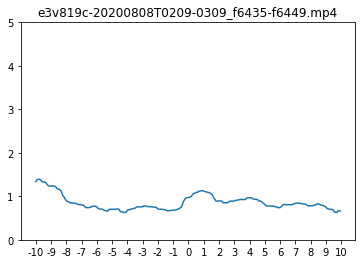

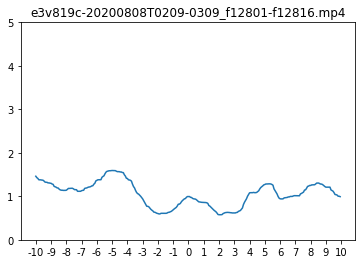

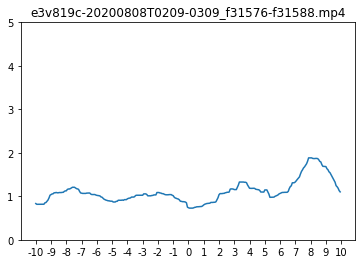

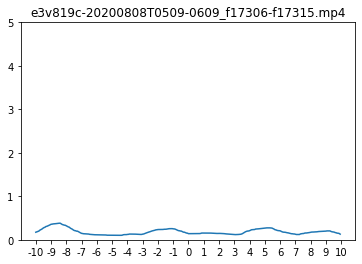

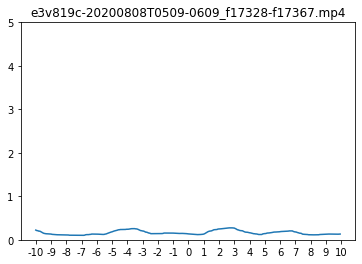

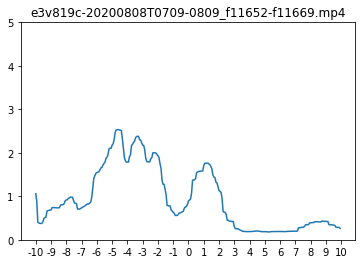

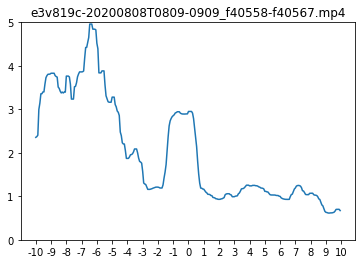

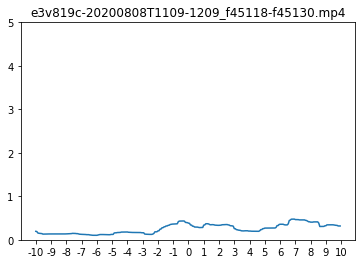

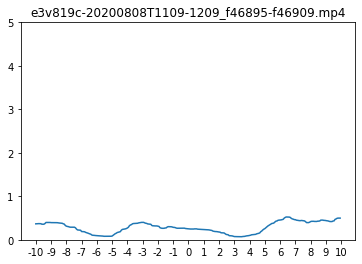

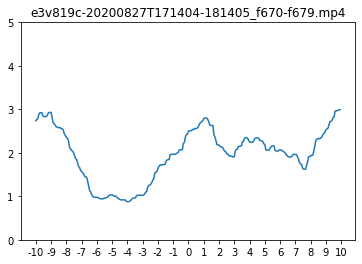

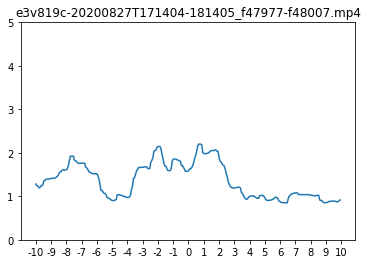

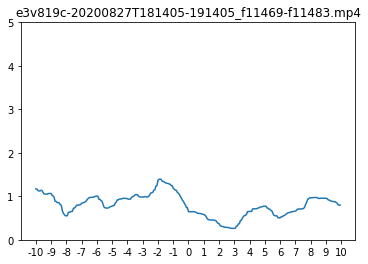

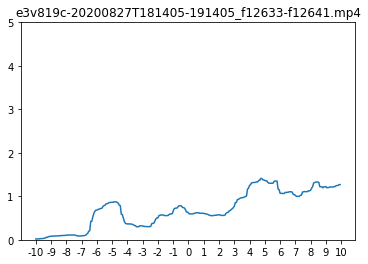

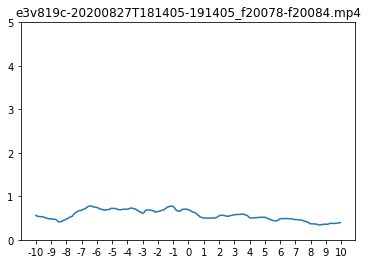

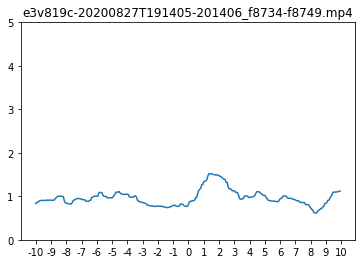

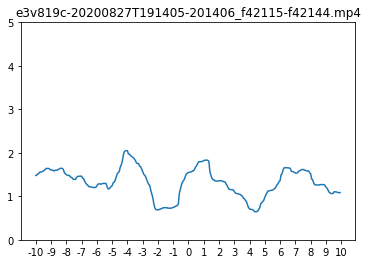

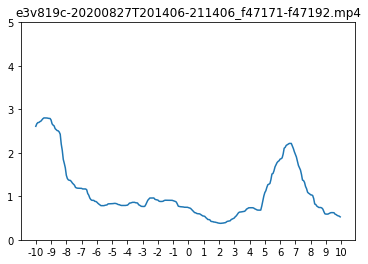

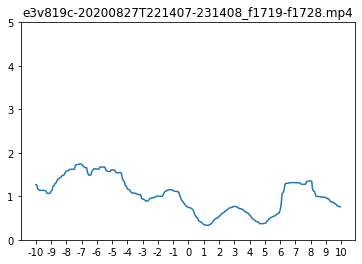

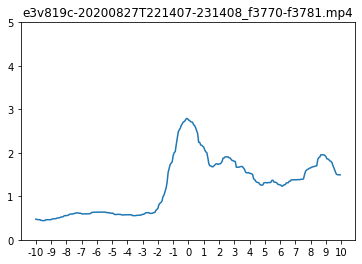

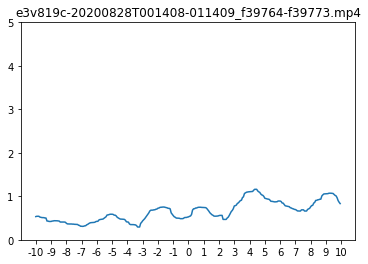

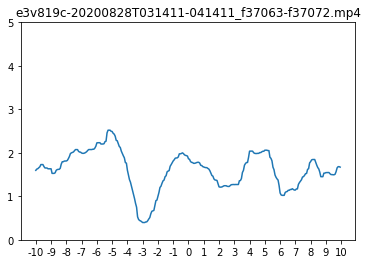

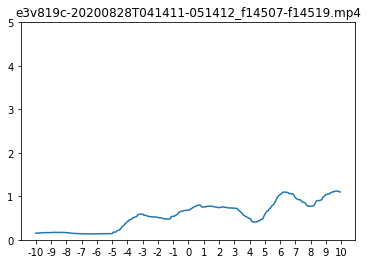

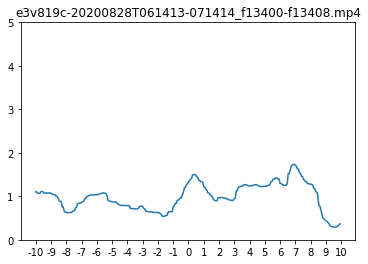

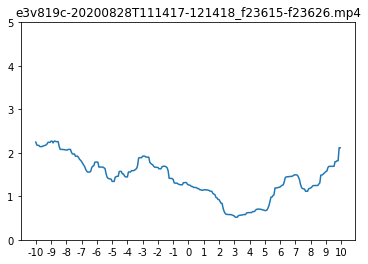

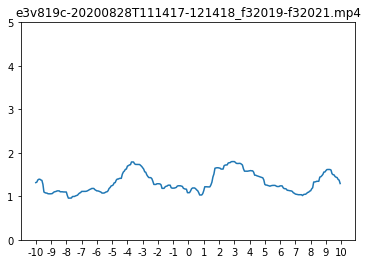

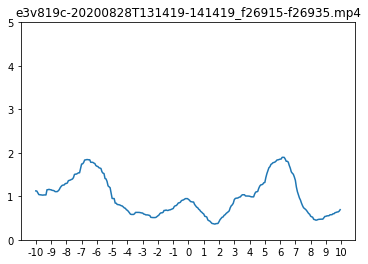

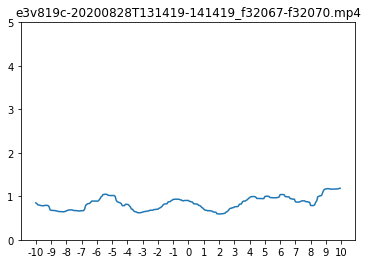

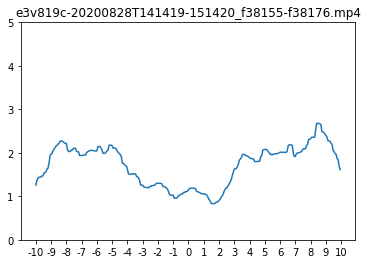

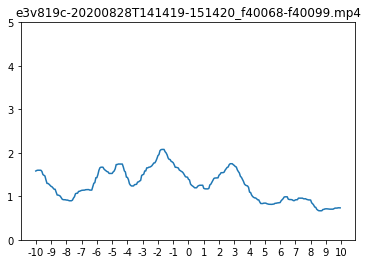

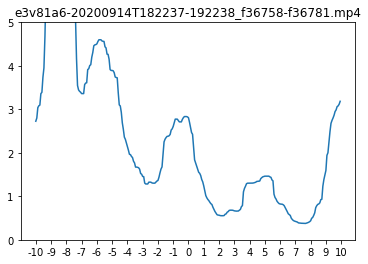

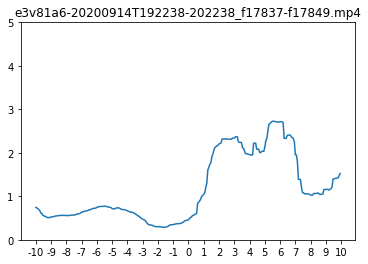

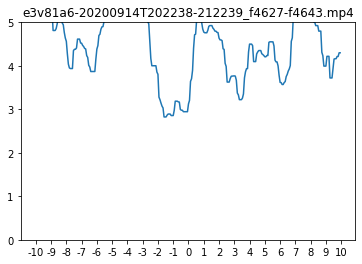

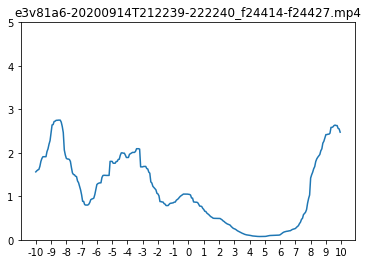

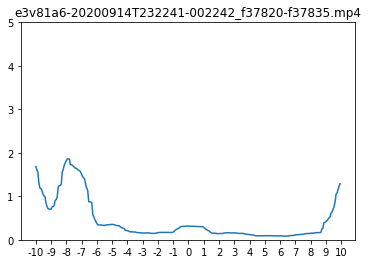

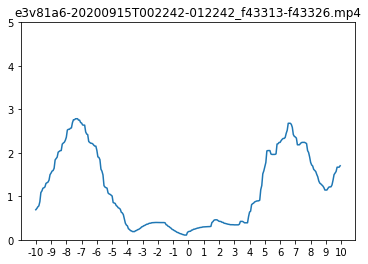

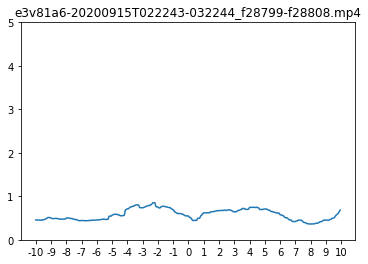

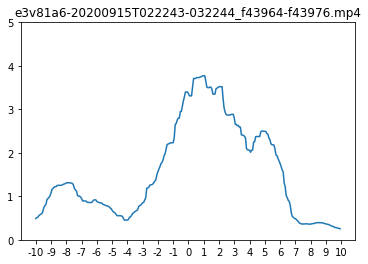

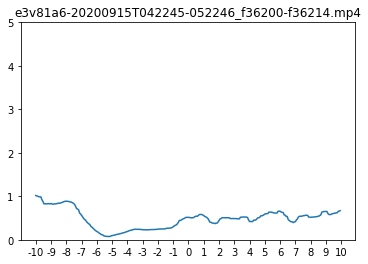

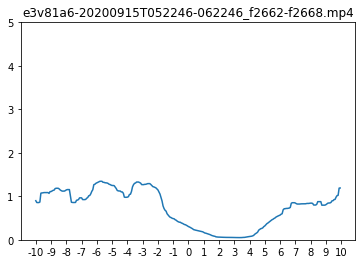

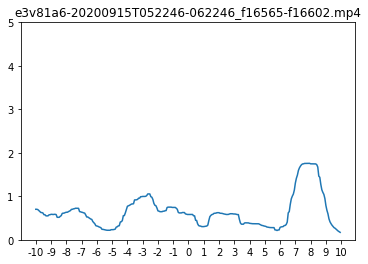

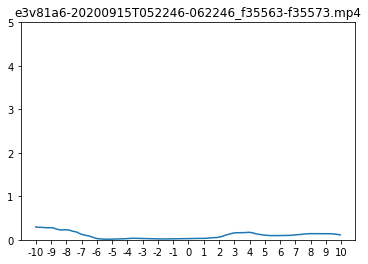

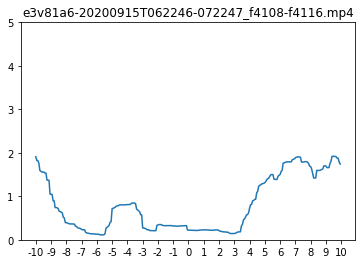

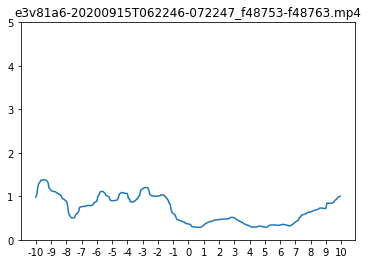

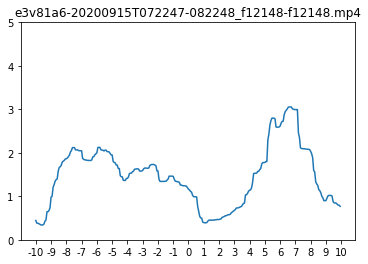

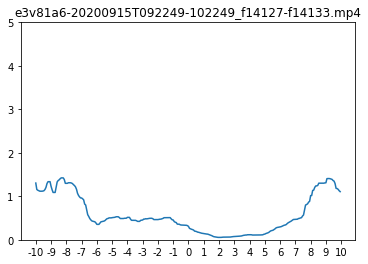

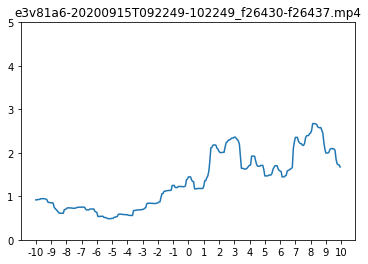

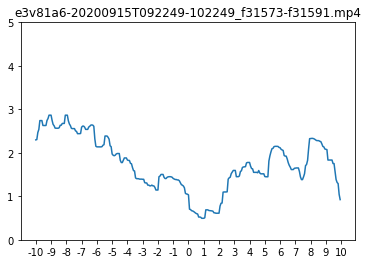

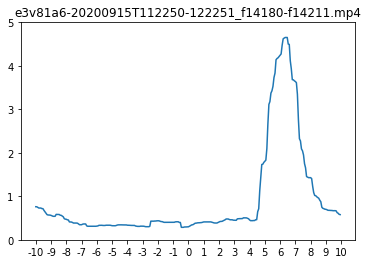

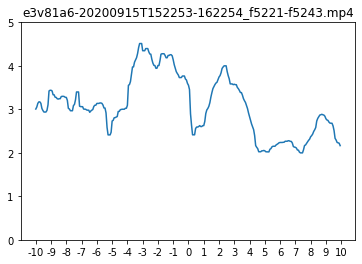

In [23]:
#plots median filter values
for vid in cleaned_vids:
    plot_flow(vid, rw_pnf)

### Twitch or Pause Plots

In [154]:
tvp

,twitch,pause
0,e3v81a6-20200914T192238-202238_f17837-f17849,e3v81a6-20200914T182237-192238_f36758-f36781
1,e3v81a6-20200914T232241-002242_f37820-f37835,e3v81a6-20200915T022243-032244_f28799-f28808
2,e3v81a6-20200915T042245-052246_f36200-f36214,e3v81a6-20200915T052246-062246_f2662-f2668
3,NaN,e3v81a6-20200915T072247-082248_f12148-f12148
4,NaN,e3v81a6-20200915T092249-102249_f14127-f14133
5,NaN,e3v81a6-20200915T092249-102249_f26430-f26437
6,NaN,e3v81a6-20200915T152253-162254_f5221-f5243


In [165]:
twitch = tvp["twitch"].values.tolist()
pause = tvp["pause"].values.tolist()

In [174]:
cleaned_twitch = clean_list(twitch)
cleaned_pause = clean_list(pause)

In [199]:
# twitch_pdf = PdfPages('twitch_plots.pdf')

In [201]:
# pause_pdf = PdfPages('pause_plots.pdf')

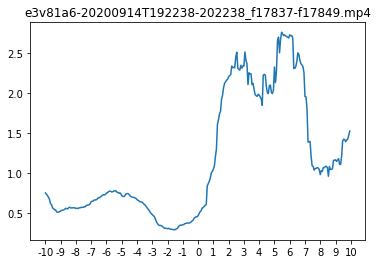

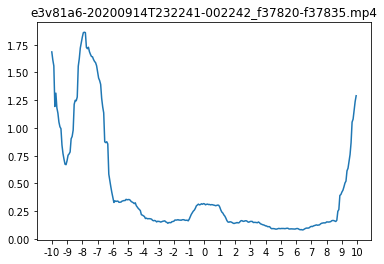

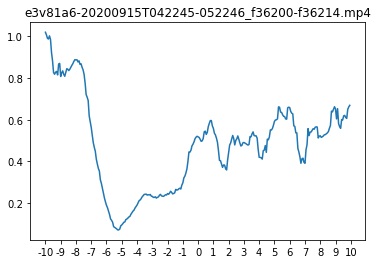

In [207]:
#plots only intervals that correlate to a twitch behavior
for vid in cleaned_twitch:
    plot_flow(vid, rw_of)

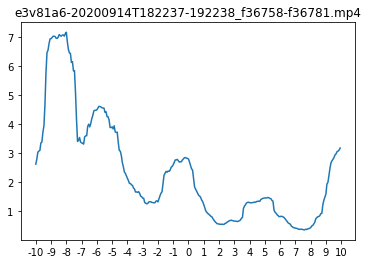

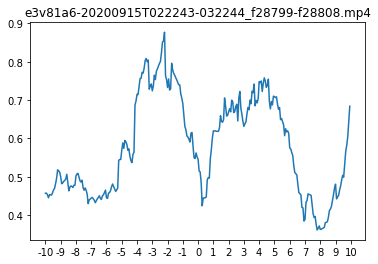

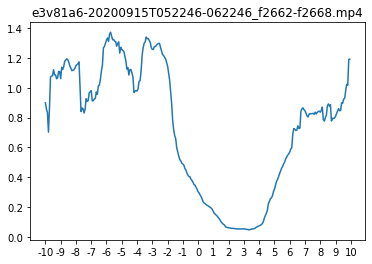

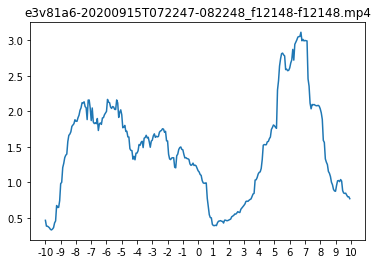

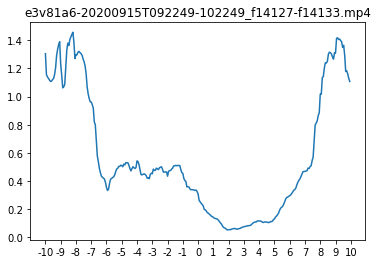

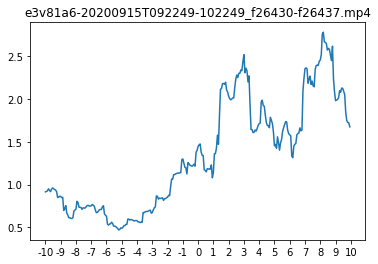

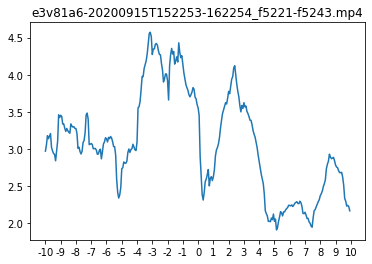

In [208]:
#plots only intervals that correlate to a pause behavior
for vid in cleaned_pause:
    plot_flow(vid, rw_of)